# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

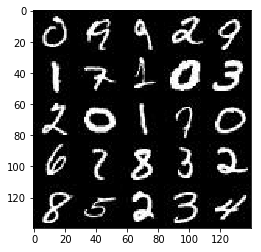

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

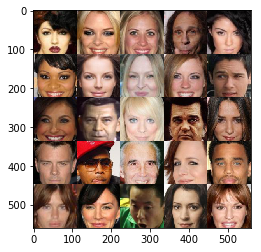

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 112, 112, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='image_input')
    z = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')

    return images, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/carnd/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x28
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7 * 7 * 512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer, 28x28 x out_dim
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    image_input, z_input, lr_input = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(image_input, z_input, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0 
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2 # Rescale from [-0.5, 0.5] to [-1, 1] 
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={image_input: batch_images, z_input: batch_z, lr_input:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={image_input: batch_images, z_input: batch_z, lr_input:learning_rate})

                if steps % 50 == 0:
                    train_loss_d = d_loss.eval({image_input: batch_images, z_input:batch_z})
                    train_loss_g = g_loss.eval({z_input:batch_z})
                    print("Epoch {}/{} Step {}...".format(epoch_i + 1, epoch_count, steps),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 200 == 0:
                    show_generator_output(sess, 25, z_input, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Step 50... Discriminator Loss: 1.7649... Generator Loss: 0.5284
Epoch 1/2 Step 100... Discriminator Loss: 1.1458... Generator Loss: 0.8283
Epoch 1/2 Step 150... Discriminator Loss: 1.6736... Generator Loss: 0.4345
Epoch 1/2 Step 200... Discriminator Loss: 1.3085... Generator Loss: 1.8513


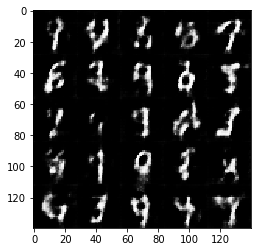

Epoch 1/2 Step 250... Discriminator Loss: 1.2399... Generator Loss: 0.9153
Epoch 1/2 Step 300... Discriminator Loss: 1.1814... Generator Loss: 1.1285
Epoch 1/2 Step 350... Discriminator Loss: 1.2417... Generator Loss: 0.7292
Epoch 1/2 Step 400... Discriminator Loss: 1.4757... Generator Loss: 0.5172


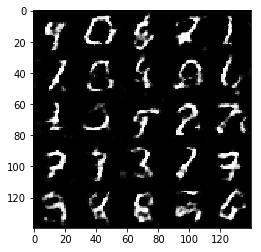

Epoch 1/2 Step 450... Discriminator Loss: 1.2113... Generator Loss: 1.2228
Epoch 1/2 Step 500... Discriminator Loss: 1.6064... Generator Loss: 1.5198
Epoch 1/2 Step 550... Discriminator Loss: 1.1225... Generator Loss: 0.9993
Epoch 1/2 Step 600... Discriminator Loss: 1.1756... Generator Loss: 0.8691


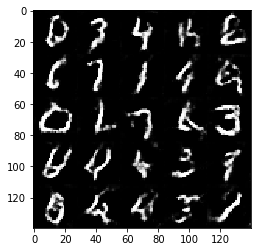

Epoch 1/2 Step 650... Discriminator Loss: 1.1971... Generator Loss: 0.7877
Epoch 1/2 Step 700... Discriminator Loss: 1.2638... Generator Loss: 1.5474
Epoch 1/2 Step 750... Discriminator Loss: 1.0975... Generator Loss: 1.0406
Epoch 1/2 Step 800... Discriminator Loss: 1.2233... Generator Loss: 0.7463


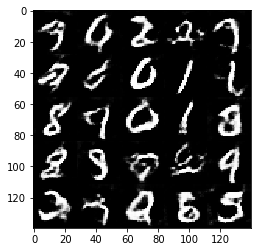

Epoch 1/2 Step 850... Discriminator Loss: 1.7402... Generator Loss: 0.4060
Epoch 1/2 Step 900... Discriminator Loss: 1.0214... Generator Loss: 1.0881
Epoch 2/2 Step 950... Discriminator Loss: 0.9722... Generator Loss: 1.0191
Epoch 2/2 Step 1000... Discriminator Loss: 1.1093... Generator Loss: 0.8959


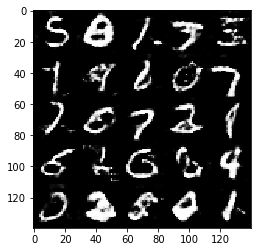

Epoch 2/2 Step 1050... Discriminator Loss: 1.4864... Generator Loss: 0.4625
Epoch 2/2 Step 1100... Discriminator Loss: 1.0273... Generator Loss: 1.1136
Epoch 2/2 Step 1150... Discriminator Loss: 0.8872... Generator Loss: 1.1155
Epoch 2/2 Step 1200... Discriminator Loss: 0.9714... Generator Loss: 1.0179


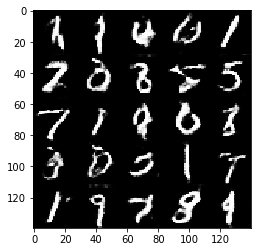

Epoch 2/2 Step 1250... Discriminator Loss: 0.7291... Generator Loss: 1.4247
Epoch 2/2 Step 1300... Discriminator Loss: 1.5688... Generator Loss: 2.8986
Epoch 2/2 Step 1350... Discriminator Loss: 1.0160... Generator Loss: 0.9872
Epoch 2/2 Step 1400... Discriminator Loss: 0.8794... Generator Loss: 1.8864


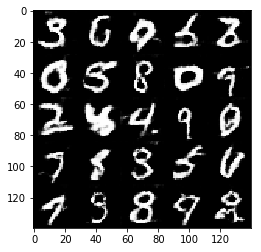

Epoch 2/2 Step 1450... Discriminator Loss: 1.1990... Generator Loss: 0.7312
Epoch 2/2 Step 1500... Discriminator Loss: 0.9742... Generator Loss: 0.9644
Epoch 2/2 Step 1550... Discriminator Loss: 3.1428... Generator Loss: 0.1338
Epoch 2/2 Step 1600... Discriminator Loss: 1.3813... Generator Loss: 0.5847


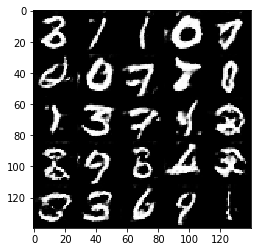

Epoch 2/2 Step 1650... Discriminator Loss: 2.0665... Generator Loss: 0.2633
Epoch 2/2 Step 1700... Discriminator Loss: 0.8215... Generator Loss: 1.2102
Epoch 2/2 Step 1750... Discriminator Loss: 0.6621... Generator Loss: 1.4733
Epoch 2/2 Step 1800... Discriminator Loss: 1.1134... Generator Loss: 1.0887


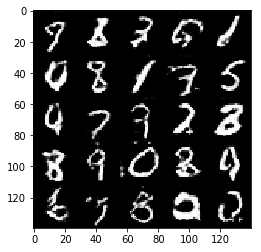

Epoch 2/2 Step 1850... Discriminator Loss: 0.8681... Generator Loss: 1.6690


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Step 50... Discriminator Loss: 0.8608... Generator Loss: 2.4244
Epoch 1/1 Step 100... Discriminator Loss: 3.0690... Generator Loss: 4.7862
Epoch 1/1 Step 150... Discriminator Loss: 0.8061... Generator Loss: 1.1438
Epoch 1/1 Step 200... Discriminator Loss: 1.5815... Generator Loss: 0.4327


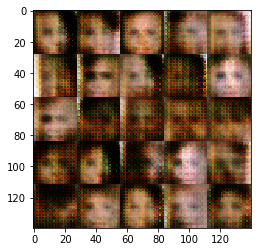

Epoch 1/1 Step 250... Discriminator Loss: 1.3336... Generator Loss: 1.2518
Epoch 1/1 Step 300... Discriminator Loss: 1.5410... Generator Loss: 1.9332
Epoch 1/1 Step 350... Discriminator Loss: 1.2324... Generator Loss: 0.9281
Epoch 1/1 Step 400... Discriminator Loss: 1.1621... Generator Loss: 0.8607


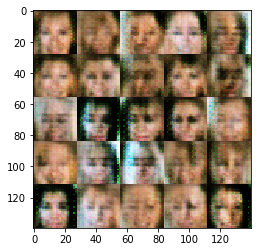

Epoch 1/1 Step 450... Discriminator Loss: 1.3919... Generator Loss: 0.7028
Epoch 1/1 Step 500... Discriminator Loss: 1.1764... Generator Loss: 0.7116
Epoch 1/1 Step 550... Discriminator Loss: 1.7453... Generator Loss: 1.4671
Epoch 1/1 Step 600... Discriminator Loss: 1.4449... Generator Loss: 1.0506


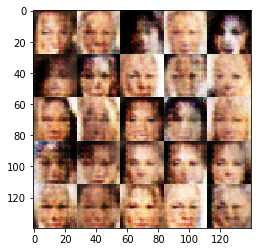

Epoch 1/1 Step 650... Discriminator Loss: 1.2451... Generator Loss: 0.9046
Epoch 1/1 Step 700... Discriminator Loss: 1.2479... Generator Loss: 0.9567
Epoch 1/1 Step 750... Discriminator Loss: 1.5386... Generator Loss: 0.4996
Epoch 1/1 Step 800... Discriminator Loss: 1.5688... Generator Loss: 0.8406


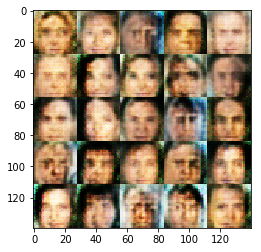

Epoch 1/1 Step 850... Discriminator Loss: 1.2830... Generator Loss: 1.2737
Epoch 1/1 Step 900... Discriminator Loss: 1.3178... Generator Loss: 0.6442
Epoch 1/1 Step 950... Discriminator Loss: 1.3030... Generator Loss: 0.7547
Epoch 1/1 Step 1000... Discriminator Loss: 1.3464... Generator Loss: 0.9454


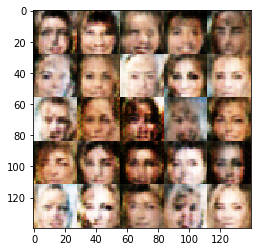

Epoch 1/1 Step 1050... Discriminator Loss: 1.4119... Generator Loss: 0.6408
Epoch 1/1 Step 1100... Discriminator Loss: 1.2212... Generator Loss: 0.8713
Epoch 1/1 Step 1150... Discriminator Loss: 1.2544... Generator Loss: 0.8936
Epoch 1/1 Step 1200... Discriminator Loss: 1.2325... Generator Loss: 0.7842


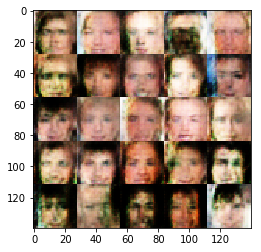

Epoch 1/1 Step 1250... Discriminator Loss: 1.4919... Generator Loss: 0.6930
Epoch 1/1 Step 1300... Discriminator Loss: 1.3396... Generator Loss: 0.6646
Epoch 1/1 Step 1350... Discriminator Loss: 1.1585... Generator Loss: 1.0993
Epoch 1/1 Step 1400... Discriminator Loss: 1.1837... Generator Loss: 0.8544


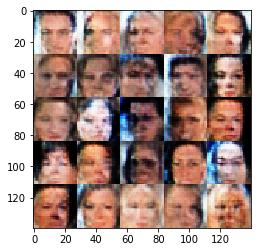

Epoch 1/1 Step 1450... Discriminator Loss: 1.3561... Generator Loss: 0.6446
Epoch 1/1 Step 1500... Discriminator Loss: 1.0374... Generator Loss: 0.8307
Epoch 1/1 Step 1550... Discriminator Loss: 1.2124... Generator Loss: 0.7689
Epoch 1/1 Step 1600... Discriminator Loss: 1.2383... Generator Loss: 0.9850


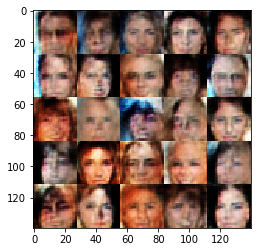

Epoch 1/1 Step 1650... Discriminator Loss: 1.1060... Generator Loss: 1.0028
Epoch 1/1 Step 1700... Discriminator Loss: 1.3364... Generator Loss: 0.6055
Epoch 1/1 Step 1750... Discriminator Loss: 1.3183... Generator Loss: 0.6988
Epoch 1/1 Step 1800... Discriminator Loss: 1.0416... Generator Loss: 0.8018


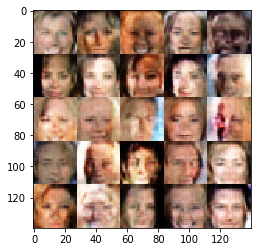

Epoch 1/1 Step 1850... Discriminator Loss: 1.4838... Generator Loss: 0.5632
Epoch 1/1 Step 1900... Discriminator Loss: 1.8231... Generator Loss: 0.3260
Epoch 1/1 Step 1950... Discriminator Loss: 0.7468... Generator Loss: 2.2639
Epoch 1/1 Step 2000... Discriminator Loss: 1.0685... Generator Loss: 1.0640


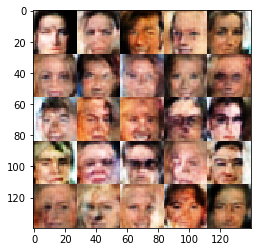

Epoch 1/1 Step 2050... Discriminator Loss: 0.7483... Generator Loss: 1.5467
Epoch 1/1 Step 2100... Discriminator Loss: 1.2202... Generator Loss: 0.6921
Epoch 1/1 Step 2150... Discriminator Loss: 0.8654... Generator Loss: 1.0692
Epoch 1/1 Step 2200... Discriminator Loss: 0.8173... Generator Loss: 1.5450


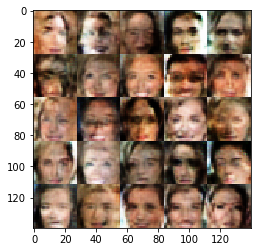

Epoch 1/1 Step 2250... Discriminator Loss: 1.2696... Generator Loss: 1.1304
Epoch 1/1 Step 2300... Discriminator Loss: 1.2300... Generator Loss: 0.7198
Epoch 1/1 Step 2350... Discriminator Loss: 0.9296... Generator Loss: 1.2066
Epoch 1/1 Step 2400... Discriminator Loss: 0.8341... Generator Loss: 1.1575


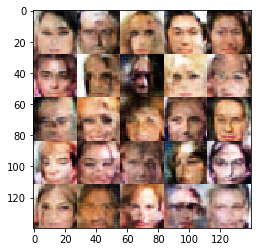

Epoch 1/1 Step 2450... Discriminator Loss: 1.3233... Generator Loss: 1.2652
Epoch 1/1 Step 2500... Discriminator Loss: 1.0354... Generator Loss: 1.9597
Epoch 1/1 Step 2550... Discriminator Loss: 1.3216... Generator Loss: 2.4784
Epoch 1/1 Step 2600... Discriminator Loss: 1.7386... Generator Loss: 2.4058


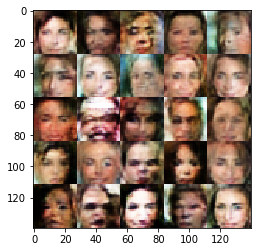

Epoch 1/1 Step 2650... Discriminator Loss: 0.8232... Generator Loss: 1.2634
Epoch 1/1 Step 2700... Discriminator Loss: 0.7093... Generator Loss: 1.5285
Epoch 1/1 Step 2750... Discriminator Loss: 1.0623... Generator Loss: 2.1146
Epoch 1/1 Step 2800... Discriminator Loss: 0.9362... Generator Loss: 1.0162


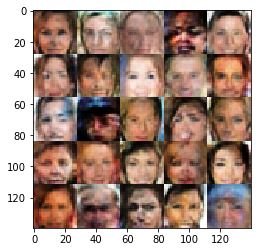

Epoch 1/1 Step 2850... Discriminator Loss: 0.8581... Generator Loss: 1.0847
Epoch 1/1 Step 2900... Discriminator Loss: 1.1204... Generator Loss: 0.7440
Epoch 1/1 Step 2950... Discriminator Loss: 0.9153... Generator Loss: 1.7906
Epoch 1/1 Step 3000... Discriminator Loss: 1.0108... Generator Loss: 1.2464


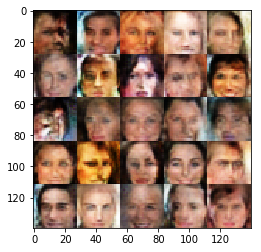

Epoch 1/1 Step 3050... Discriminator Loss: 0.4972... Generator Loss: 2.9599
Epoch 1/1 Step 3100... Discriminator Loss: 0.5811... Generator Loss: 2.6229
Epoch 1/1 Step 3150... Discriminator Loss: 1.5981... Generator Loss: 0.4362


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.